In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from rich.progress import Progress
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import minmax_scale, StandardScaler

In [2]:
class Topsis:
    def __init__(self, X, weights, criteria):
        self.X = np.asarray(X, dtype="float64")
        self.weights = np.asarray(weights, dtype="float64")
        self.weights /= np.sum(self.weights)
        self.criteria = np.asarray(criteria, dtype=bool)
        self._fitted = False

    def fit(self):
        X_norm = self.X.copy()
        norm_coefs = np.sum(X_norm**2, axis=0) ** 0.5
        X_norm /= norm_coefs
        X_norm *= self.weights

        # Determine the best and worst alternatives
        X_min, X_max = X_norm.min(axis=0), X_norm.max(axis=0)
        best = np.where(self.criteria, X_max, X_min)
        worst = np.where(self.criteria, X_min, X_max)

        # Determine the best and worst distances
        self.best_distance = np.sum((X_norm - best) ** 2, axis=1) ** 0.5
        self.worst_distance = np.sum((X_norm - worst) ** 2, axis=1) ** 0.5
        self._fitted = True

    def predict(self):
        if not self._fitted:
            raise ValueError("The model has not been fitted yet")
        denom = self.best_distance + self.worst_distance
        return self.best_distance / denom, self.worst_distance / denom

    def fit_predict(self):
        if not self._fitted:
            self.fit()
        return self.predict()

In [3]:
def get_performance(df, match_id):
    match_df = df[df["match_id"] == match_id]
    eval_df = match_df.copy()

    # Explode the columns to duplicate columns for each player
    eval_df["player_id"] = None
    for i in eval_df.index:
        eval_df.at[i, "player_id"] = (1, 2)
    eval_df = (
        eval_df.explode("player_id")
        .reset_index(names="point_id")
        .set_index(["point_id", "player_id"])
    )

    # Assign info to the corresponding player
    sep_cols = ["ace", "winner", "break_pt_won", "double_fault", "unf_err"]
    eval_df_spec_criteria = [True, True, True, False, False]
    for col in sep_cols:
        eval_df[col] = eval_df.apply(lambda x: x[f"p{x.name[1]}_{col}"], axis=1)

    # Victor by server or receiver
    eval_df["victor_by_server"] = eval_df.apply(
        lambda x: int(x["point_victor"] == x.name[1] and x["server"] == x.name[1]),
        axis=1,
    )
    eval_df["victor_by_receiver"] = eval_df.apply(
        lambda x: int(x["point_victor"] == x.name[1] and x["server"] != x.name[1]),
        axis=1,
    )
    sep_cols = ["victor_by_server", "victor_by_receiver"] + sep_cols
    eval_df_spec_criteria = [True, True] + eval_df_spec_criteria

    # Entropy weight method (EWM)
    eval_df_spec = eval_df[sep_cols]
    scaled_values = minmax_scale(eval_df_spec.values, feature_range=(0.01, 0.99))
    norm_values = scaled_values / np.sum(scaled_values, axis=0)
    g = 1 + 1 / np.log(len(eval_df_spec)) * np.sum(
        norm_values * np.log(norm_values), axis=0
    )
    eval_df_spec_weights = g / np.sum(g)

    # TOPSIS
    topsis = Topsis(eval_df_spec.values, eval_df_spec_weights, eval_df_spec_criteria)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        eval_df_spec["performance"] = topsis.fit_predict()[1]

    # Store performance data
    p1_performance = eval_df_spec.loc[
        eval_df_spec.index.get_level_values("player_id") == 1, "performance"
    ]
    p2_performance = eval_df_spec.loc[
        eval_df_spec.index.get_level_values("player_id") == 2, "performance"
    ]
    p1_performance.index = p1_performance.index.droplevel("player_id")
    p2_performance.index = p2_performance.index.droplevel("player_id")
    return pd.concat([p1_performance, p2_performance], axis=1, keys=["p1", "p2"])

In [4]:
df = pd.read_csv("wimbledon.csv")

In [5]:
window_size = 6
player_name = "Novak Djokovic"
df = df[(df["player1"] == player_name) | (df["player2"] == player_name)]

In [6]:
df["swing"] = 0
for match_id in df["match_id"].unique():
    df_performance = get_performance(df, match_id)
    df_perf_diff = df_performance["p1"] - df_performance["p2"]
    ser_momentum = df_perf_diff.rolling(window_size).sum()
    ser_momentum = ser_momentum.fillna(df_perf_diff.cumsum())
    for i, sign_diff in (
        np.sign(ser_momentum).diff().where(lambda x: x != 0).dropna().items()
    ):
        df.loc[i, "swing"] = 1 if sign_diff > 0 else -1
df["swing"].value_counts()

swing
 0    990
 1    101
-1    100
Name: count, dtype: int64

In [7]:
def this_transform(x, kind, primary):
    target = f"{kind}_victor"
    if x[target] == primary:
        return 1
    if x[target] == 0:
        return 0
    return -1

In [8]:
df_p1 = df.rename(columns=lambda x: x.replace("p1_", "")).rename(
    columns=lambda x: x.replace("p2_", "other_")
)
df_p1["is_server"] = df_p1.apply(lambda x: x["server"] == 1, axis=1)
for kind in ["point", "game", "set"]:
    df_p1[f"this_{kind}"] = df_p1.apply(lambda x: this_transform(x, kind, 1), axis=1)
df_p2 = df.rename(columns=lambda x: x.replace("p2_", "")).rename(
    columns=lambda x: x.replace("p1_", "other_")
)
df_p2["is_server"] = df_p2.apply(lambda x: x["server"] == 2, axis=1)
for kind in ["point", "game", "set"]:
    df_p2[f"this_{kind}"] = df_p1.apply(lambda x: this_transform(x, kind, 2), axis=1)
df_p2["swing"] = -df_p2["swing"]  # Invert the swing column
df_info = pd.concat([df_p1, df_p2], keys=["p1", "p2"])

In [9]:
valid_vals = ["0", "15", "30", "40", "AD"]
valid_mask = df_info["score"].isin(valid_vals) & df_info["other_score"].isin(valid_vals)
print(f"{len(df_info) - valid_mask.sum()} invalid out of {len(df_info)}")
df_info = df_info[valid_mask]

120 invalid out of 2382


In [10]:
mapping = {"0": 0, "15": 1, "30": 2, "40": 3, "AD": 4}
df_info["feat_score"] = df_info["score"].map(mapping)
df_info["feat_score_diff"] = df_info["feat_score"] - df_info["other_score"].map(mapping)
df_info["feat_deuce_ad"] = 0
for i in df_info.index:
    if df_info.loc[i, "score"] == "AD":
        df_info.at[i, "feat_deuce_ad"] = 1
    elif df_info.loc[i, "other_score"] == "AD":
        df_info.at[i, "feat_deuce_ad"] = -1
df_info["feat_point_count"] = (
    df_info.groupby(
        (df_info["game_no"] != df_info["game_no"].shift(1)).cumsum()
    ).cumcount()
    + 1
)

In [11]:
df_info["feat_game_diff"] = df_info["games"] - df_info["other_games"]
df_info["feat_set_diff"] = df_info["sets"] - df_info["other_sets"]

In [12]:
df_info["feat_cont_victors"] = (
    (df_info["this_point"] == 1)
    .groupby((df_info["this_point"] != df_info["this_point"].shift()).cumsum())
    .cumsum()
)
df_info["feat_cont_losers"] = (
    (df_info["this_point"] == -1)
    .groupby((df_info["this_point"] != df_info["this_point"].shift()).cumsum())
    .cumsum()
)

In [13]:
df_info["feat_unf_err"] = df_info["unf_err"]
df_info["feat_unf_errs_game"] = df_info.groupby(["match_id", "set_no", "game_no"])[
    "unf_err"
].cumsum()
df_info["feat_unf_errs_set"] = df_info.groupby(["match_id", "set_no"])[
    "unf_err"
].cumsum()
df_info["feat_unf_err_oppn"] = df_info["other_unf_err"]
df_info["feat_double_fault"] = df_info["double_fault"]
df_info["feat_double_faults_game"] = df_info.groupby(["match_id", "set_no", "game_no"])[
    "double_fault"
].cumsum()
df_info["feat_double_faults_set"] = df_info.groupby(["match_id", "set_no"])[
    "double_fault"
].cumsum()
df_info["feat_double_fault_oppn"] = df_info["other_double_fault"]

In [14]:
df_info["feat_ace"] = df_info["ace"]
df_info["feat_aces_game"] = df_info.groupby(["match_id", "set_no", "game_no"])[
    "ace"
].cumsum()
df_info["feat_aces_set"] = df_info.groupby(["match_id", "set_no"])["ace"].cumsum()
df_info["feat_ace_oppn"] = df_info["other_ace"]
df_info["feat_winner"] = df_info["winner"]
df_info["feat_winners_game"] = df_info.groupby(["match_id", "set_no", "game_no"])[
    "winner"
].cumsum()
df_info["feat_winners_set"] = df_info.groupby(["match_id", "set_no"])["winner"].cumsum()
df_info["feat_winner_oppn"] = df_info["other_winner"]

In [15]:
df_info["feat_break_pt_missed"] = df_info["break_pt_missed"]
df_info["feat_break_pt_won"] = df_info["break_pt_won"]
df_info["feat_break_pt_oppn_missed"] = df_info["other_break_pt_missed"]
df_info["feat_break_pt_oppn_won"] = df_info["other_break_pt_won"]

In [16]:
df_info["feat_speed_mph"] = df_info["speed_mph"] * df_info["is_server"].map(
    {True: 1, False: 0}
)
df_info["feat_speed_mph_oppn"] = df_info["speed_mph"] * df_info["is_server"].map(
    {True: 0, False: 1}
)

In [17]:
df_info["feat_distance_run"] = df_info["distance_run"]
df_info["feat_distance_run_game"] = df_info.groupby(["match_id", "set_no", "game_no"])[
    "distance_run"
].cumsum()

In [18]:
df_info["feat_net_pt"] = df_info["net_pt"]
df_info["feat_net_pt_won"] = df_info["net_pt_won"]

In [19]:
df_info["feat_is_server"] = df_info["is_server"].astype(int)
df_info["feat_rally_count"] = df_info["rally_count"]

In [20]:
df_info["elapsed_time_td"] = pd.to_timedelta(df_info["elapsed_time"])
df_info["feat_time"] = (
    df_info.groupby("match_id")["elapsed_time_td"].diff().dt.total_seconds()
)
df_info["feat_time"] = df_info["feat_time"].fillna(0)

In [21]:
df_info["swing"] = df_info["swing"].where(df_info["swing"] == 0, 1)
df_info = df_info[df_info.index.get_level_values(0) == "p1"]
df_info = df_info.filter(regex="^feat|^swing$")
df_info = df_info.rename(columns=lambda x: x.replace("feat_", ""))

In [22]:
for feat in df_info.columns:
    nan_count = df_info[feat].isna().sum()
    if nan_count > 0:
        print(f"{feat} has {nan_count} missing values")
df_info[:] = SimpleImputer(strategy="most_frequent").fit_transform(df_info)
assert not df_info.isna().any().any()

speed_mph has 24 missing values
speed_mph_oppn has 24 missing values


In [23]:
def plot_correlation(df_info, *, method, scipy_func, description, storage):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), sharey=True)

    # Correlation coefficient
    correlation = (
        df_info.corr(method=method)["swing"].drop("swing", axis=0).sort_values()
    )
    bars = ax1.barh(correlation.index, correlation)
    ax1.bar_label(bars, fmt="%.3f", padding=5, fontsize=8)
    xlim = ax1.get_xlim()
    ax1.set_xlim(xlim[0] - 0.01, xlim[1] + 0.01)
    ax1.set_title("Coefficient")
    ax1.tick_params(axis="both", labelsize=8)

    # P-value
    correlation_p = (
        df_info.corr(lambda x, y: scipy_func(x, y).pvalue)["swing"]
        .drop("swing", axis=0)
        .sort_values(ascending=False)
    )
    p_bars = ax2.barh(correlation_p.index, correlation_p, color="lightgrey")
    ax2.bar_label(p_bars, fmt="%.1e", padding=5, fontsize=8)
    ax2.axvline(0.05, color="red", linestyle="--", lw=1)
    xlim = ax2.get_xlim()
    ax2.set_xlim(0, xlim[1] + 0.1)
    ax2.set_title("P-value")
    ax2.tick_params(axis="both", labelsize=8)

    storage[method] = (correlation, correlation_p)
    plt.suptitle(f"{description} correlation of various factors with the swing")
    plt.tight_layout()
    plt.show()

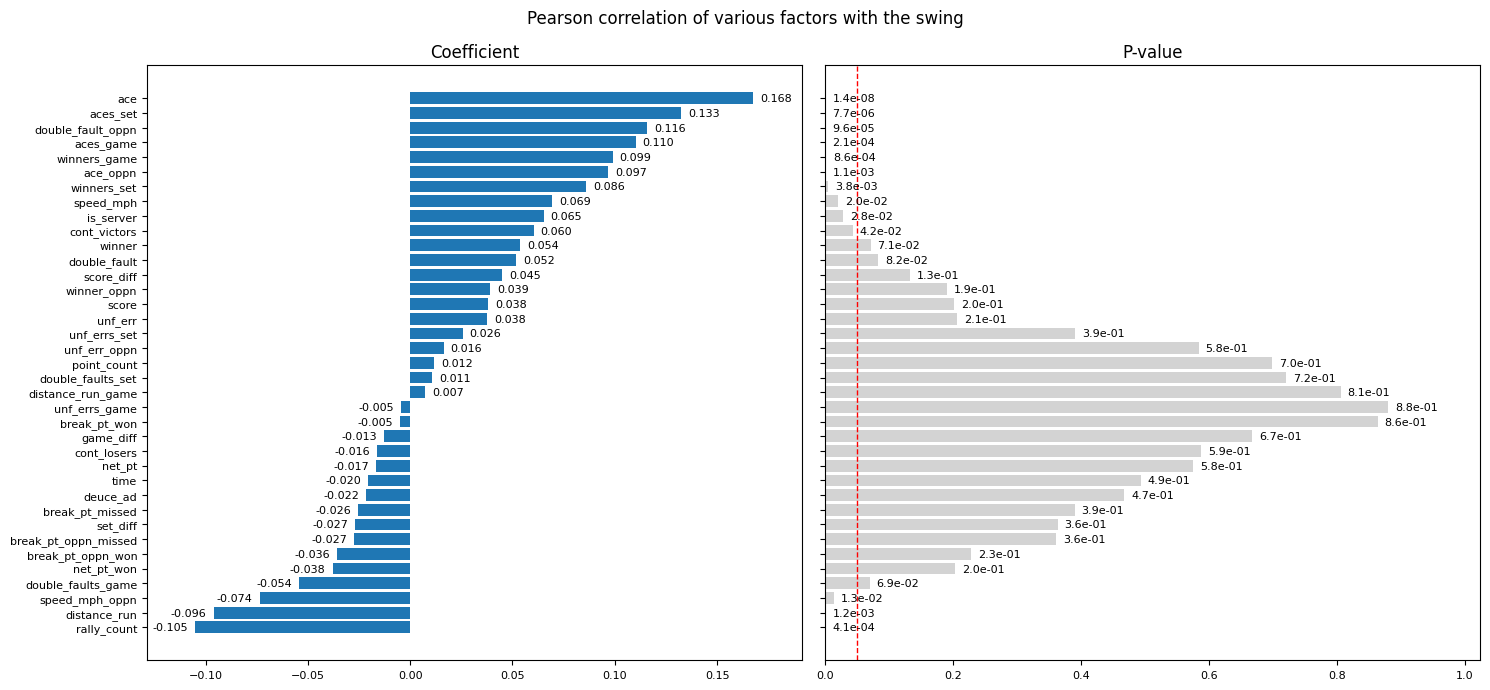

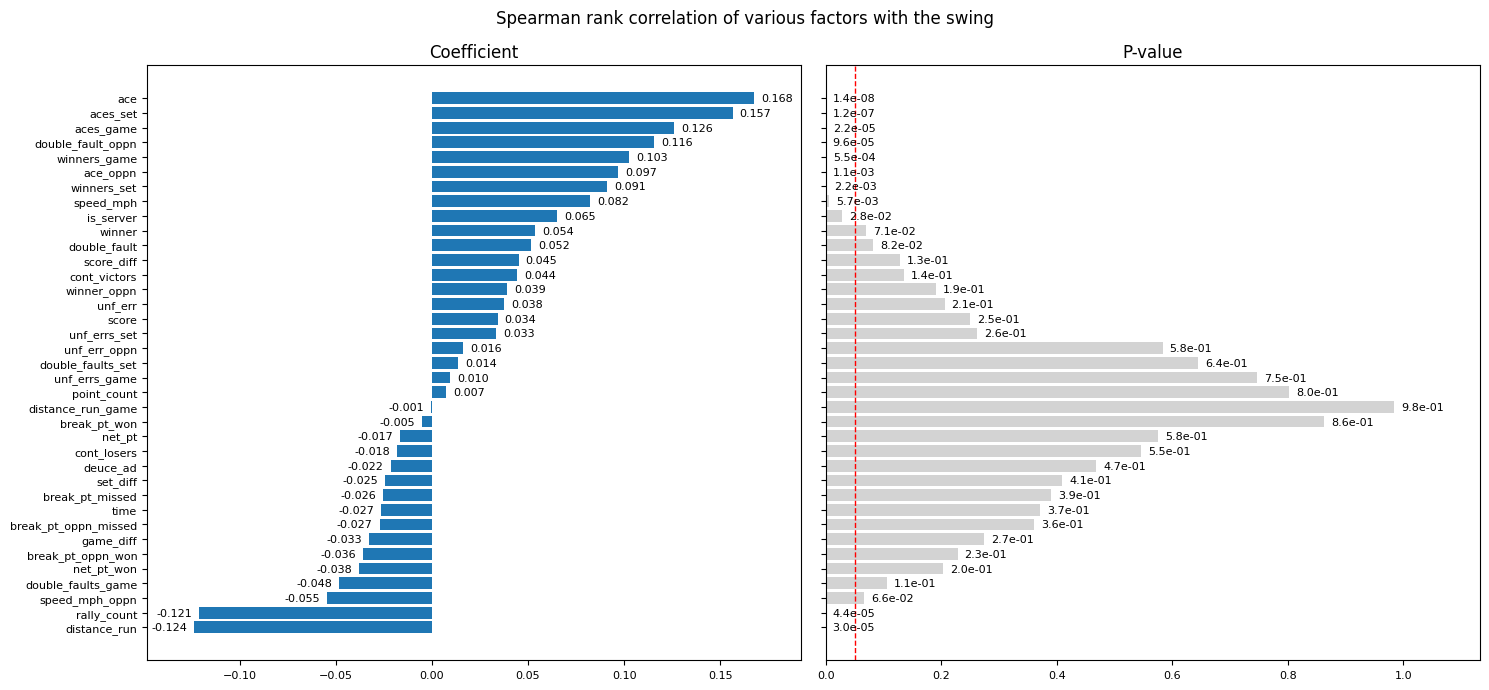

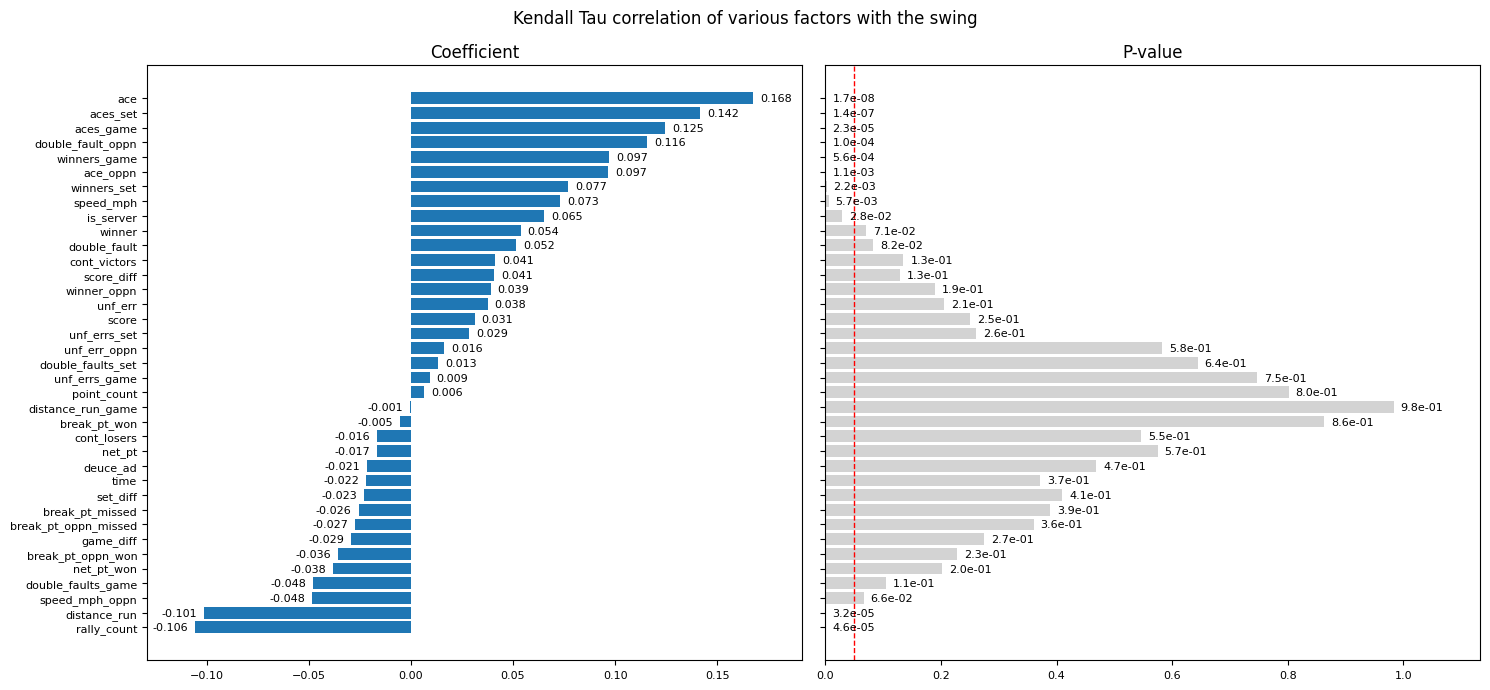

In [24]:
correlation_storage = {}
plot_correlation(
    df_info,
    method="pearson",
    scipy_func=stats.pearsonr,
    description="Pearson",
    storage=correlation_storage,
)
plot_correlation(
    df_info,
    method="spearman",
    scipy_func=stats.spearmanr,
    description="Spearman rank",
    storage=correlation_storage,
)
plot_correlation(
    df_info,
    method="kendall",
    scipy_func=stats.kendalltau,
    description="Kendall Tau",
    storage=correlation_storage,
)

In [25]:
selected_method = "pearson"
selected_corr, selected_corrp = correlation_storage[selected_method]
selected_features = selected_corrp[selected_corrp <= 0.05].index
X, y = df_info[selected_features], df_info["swing"]
X.shape, y.shape

((1131, 13), (1131,))

In [26]:
no_swing_count, swing_count = (y == 0).sum(), (y == 1).sum()
print(f"No swing: {no_swing_count}; Swing: {swing_count}")
sampling_strategy = {0: no_swing_count, 1: max(int(no_swing_count / 10), swing_count)}
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("sample", SMOTE(random_state=42, sampling_strategy=sampling_strategy)),
        ("clf", RandomForestClassifier(n_estimators=500, random_state=42)),
    ]
)
pipeline.fit(X, y)

No swing: 942; Swing: 189


Pipeline(steps=[('scaler', StandardScaler()),
                ('sample',
                 SMOTE(random_state=42, sampling_strategy={0: 942, 1: 189})),
                ('clf',
                 RandomForestClassifier(n_estimators=500, random_state=42))])

In [27]:
clf = pipeline["clf"]
df_importances = pd.DataFrame(
    {"feature": X.columns, "importance": clf.feature_importances_}
)
df_importances.set_index("feature").sort_values("importance", ascending=False).T

feature,distance_run,winners_set,speed_mph_oppn,speed_mph,aces_set,rally_count,cont_victors,winners_game,aces_game,ace,ace_oppn,is_server,double_fault_oppn
importance,0.257676,0.137096,0.116111,0.115249,0.093081,0.091585,0.066305,0.059022,0.016515,0.015535,0.013292,0.009719,0.008814


In [28]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df_info.loc[X.index, "swing_pred"] = clf.predict(X)
df_info["swing_pred"] = df_info["swing_pred"].astype(int)
df_info[["swing", "swing_pred"]].value_counts().to_frame().sort_index()

,,count
swing,swing_pred,
0,0,942
1,0,189


In [29]:
def get_false_preds(df_info, indices, tolerance):
    false_positives, false_negatives = [], []
    for i, row in df_info.loc[indices].iterrows():
        ser_window = df_info.loc[
            df_info.index.get_level_values(1).isin(range(i[1], i[1] + tolerance + 1)),
            "swing",
        ]
        if row["swing_pred"] == 1:  # Predicted positive
            if len(ser_window[ser_window == 1]) == 0:  # No positive in window
                false_positives.append(i)
        else:  # Predicted negative
            if len(ser_window[ser_window == 0]) == 0:  # No negative in window
                false_negatives.append(i)
    return false_positives, false_negatives

Output()

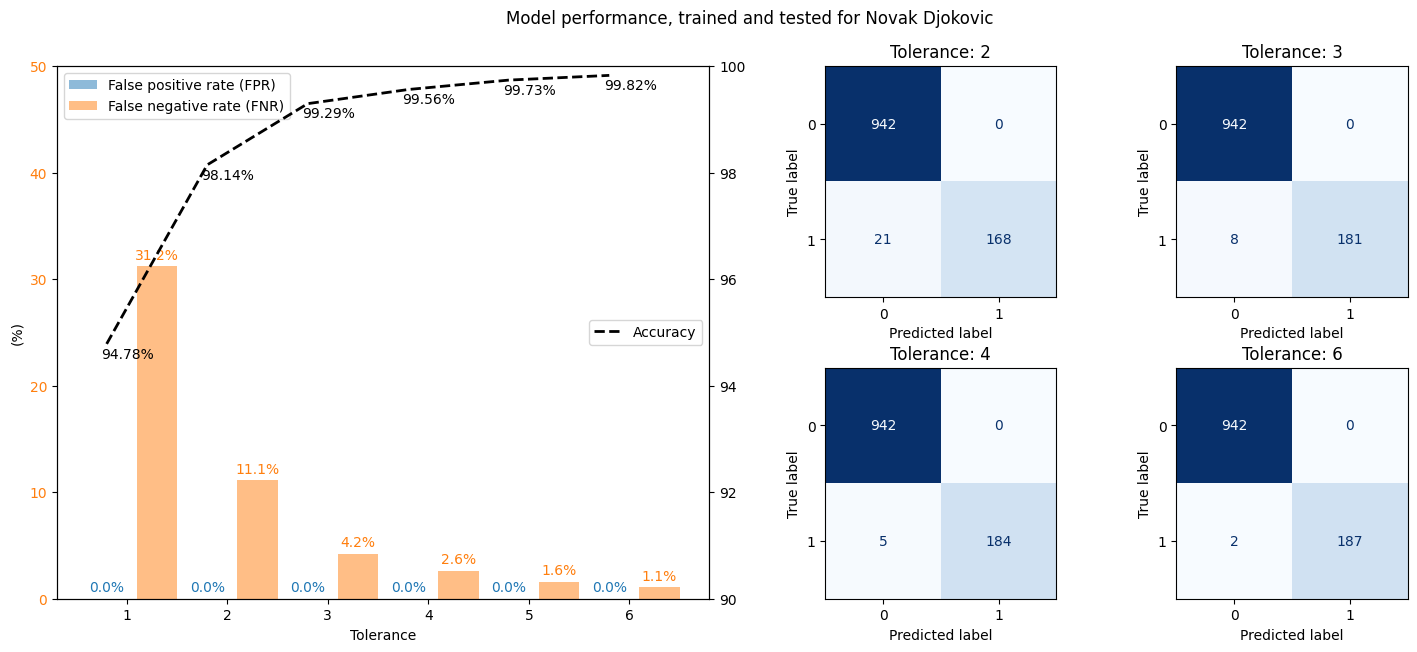

In [30]:
n_positives, n_negatives = len(y[y == 1]), len(y[y == 0])
fig = plt.figure(figsize=(14, 7))
subfig1, subfig2 = fig.subfigures(1, 2, width_ratios=[1, 1], wspace=0.1)
ax1 = subfig1.subplots()
ax2 = subfig2.subplots(2, 2)

tolerances = np.arange(1, 7)
conf_map = {2: (0, 0), 3: (0, 1), 4: (1, 0), 6: (1, 1)}
accs, fp_percs, fn_percs = [], [], []
with Progress(transient=True) as progress:
    task = progress.add_task("Processing...", total=len(tolerances))
    for tolerance in tolerances:
        false_positives, false_negatives = get_false_preds(df_info, y.index, tolerance)
        fp, fn = len(false_positives), len(false_negatives)
        tp, tn = n_positives - fn, n_negatives - fp
        accs.append((tp + tn) / len(y) * 100)
        fp_percs.append(fp / (fp + tn) * 100)
        fn_percs.append(fn / (fn + tp) * 100)
        if tolerance in conf_map:
            curax = ax2[*conf_map[tolerance]]
            curax.set_title(f"Tolerance: {tolerance}")
            ConfusionMatrixDisplay(
                confusion_matrix=np.array([[tn, fp], [fn, tp]]), display_labels=[0, 1]
            ).plot(ax=curax, cmap="Blues", colorbar=False)
        progress.update(task, advance=1)

rects_fp = ax1.bar(
    tolerances, fp_percs, width=0.4, label="False positive rate (FPR)", alpha=0.5
)
ax1.bar_label(rects_fp, fmt="%.1f%%", padding=3, color="tab:blue")
rects_fn = ax1.bar(
    tolerances + 0.5, fn_percs, width=0.4, label="False negative rate (FNR)", alpha=0.5
)
ax1.bar_label(rects_fn, fmt="%.1f%%", padding=3, color="tab:orange")
ax1.set_xticks(tolerances + 0.2)
ax1.set_xticklabels(tolerances)
ax1.set_xlabel("Tolerance")
ax1.set_ylabel("(%)")
ax1.set_ylim(0, 50)
ax1.tick_params(axis="y", labelcolor="tab:orange")
ax1.legend(loc="upper left")
ax1_ = ax1.twinx()
ax1_.plot(tolerances, accs, label="Accuracy", color="black", lw=2, linestyle="--")
for i, (tolerance, acc) in enumerate(zip(tolerances, accs)):
    ax1_.annotate(
        f"{acc:.2f}%",
        (tolerance, acc),
        textcoords="offset points",
        xytext=(15, -10),
        ha="center",
        fontsize=10,
    )
ax1_.set_ylim(90, 100)
ax1_.legend(loc="center right")

fig.suptitle(f"Model performance, trained and tested for {player_name}")
fig.tight_layout()
plt.show()